Clasificación y transformers con datasets financieros.

Importamos las librerías.

Para descargarme el dataset de HF, me he tenido que instalar la siguiente libreria:

Es importante saber que una vez se instala, colab pedirá reiniciar la sesión.

In [ ]:
!pip install datasets

In [ ]:
!pip install -q --upgrade keras-nlp
!pip install -q --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.1/548.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from tensorflow.keras import layers

Cargamos el dataset.

Cuando nos porgamos acargar el dataset, te hara la siguiente pregunta: 'Do you wish to run the custom code?' --- hay que responder 'y'

In [ ]:
from datasets import load_dataset
dataset = load_dataset('financial_phrasebank', 'sentences_allagree')

print(dataset['train'][0])


financial_phrasebank.py:   0%|          | 0.00/6.04k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.88k [00:00<?, ?B/s]

The repository for financial_phrasebank contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/financial_phrasebank.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


FinancialPhraseBank-v1.0.zip:   0%|          | 0.00/682k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

{'sentence': 'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .', 'label': 1}


In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2264
    })
})


In [ ]:
print(dataset['train'].column_names)

['sentence', 'label']


In [ ]:
for i in range(5):
    print(f"Ejemplo {i+1}:")
    print(f"  Oración: {dataset['train'][i]['sentence']}")
    print(f"  Etiqueta: {dataset['train'][i]['label']}")
    print("\n")

Ejemplo 1:
  Oración: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
  Etiqueta: 1


Ejemplo 2:
  Oración: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
  Etiqueta: 2


Ejemplo 3:
  Oración: In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .
  Etiqueta: 2


Ejemplo 4:
  Oración: Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .
  Etiqueta: 2


Ejemplo 5:
  Oración: Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .
  Etiqueta: 2




In [ ]:
#Para ver la distribución de las etiquetas:
from collections  import Counter
label_counts = Counter(dataset['train']['label'])

for label, count in label_counts.items():
    print(f"Etiqueta {label}: {count} ejemplos")

Etiqueta 1: 1391 ejemplos
Etiqueta 2: 570 ejemplos
Etiqueta 0: 303 ejemplos


In [ ]:
#Antes de nada, vamos a analizar la distribución de la longotud de las secuencias por clases.
lengths_0 = [len(sentence.split()) for sentence, label in zip(dataset['train']['sentence'], dataset['train']['label']) if label == 0]
lengths_1 = [len(sentence.split()) for sentence, label in zip(dataset['train']['sentence'], dataset['train']['label']) if label == 1]
lengths_2 = [len(sentence.split()) for sentence, label in zip(dataset['train']['sentence'], dataset['train']['label']) if label == 2]

mean_length_0 = sum(lengths_0) / len(lengths_0)
mean_length_1 = sum(lengths_1) / len(lengths_1)
mean_length_2 = sum(lengths_2) / len(lengths_2)

print(f"Media de la longitud de secuencias para Clase 0: {mean_length_0:.2f}")
print(f"Media de la longitud de secuencias para Clase 1: {mean_length_1:.2f}")
print(f"Media de la longitud de secuencias para Clase 2: {mean_length_2:.2f}")

Media de la longitud de secuencias para Clase 0: 24.80
Media de la longitud de secuencias para Clase 1: 20.93
Media de la longitud de secuencias para Clase 2: 24.88


Un Max Len de 30, podria ser un buena longitud maxima para estas secuencias.

In [ ]:
#Convertimos el dataset a dataframe.
import pandas as pd
df = pd.DataFrame(dataset['train'])
df['label'].value_counts()

,count
label,
1,1391
2,570
0,303


In [ ]:
#Igualamos el numero de ejemplos de las 2 primeras clases a tercera.
from sklearn.utils import resample
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]
class_2 = df[df['label'] == 2]

n_samples = len(class_0)

class_1_downsampled = resample(class_1,
                               replace=False,
                               n_samples=n_samples,
                               random_state=42)

class_2_downsampled = resample(class_2,
                               replace=False,
                               n_samples=n_samples,
                               random_state=42)

balanced_df = pd.concat([class_0, class_1_downsampled, class_2_downsampled])
balanced_df = balanced_df.sample(frac=1, random_state=122)

In [ ]:
balanced_df

,sentence,label
129,"However , sales returned to growth in April-Ju...",2
492,CapMan has six investment areas CapMan Buyout ...,1
1319,Okmetic revised its 2010 financial outlook bas...,1
2051,Kone shares dropped 4.1 percent to x20ac 43 U...,0
1240,Her present position is the director of Stockm...,1
...,...,...
2228,The announcement pushed Freenet shares down 6....,0
25,"In January , traffic , measured in revenue pas...",2
1098,"The order includes a new Crecent former , head...",1
1356,"So far as is known , he did not sell shares th...",1


In [ ]:
balanced_df['label'].value_counts()

,count
label,
2,303
1,303
0,303


Primer modelo: LSTM Bidireccional.

In [ ]:
#Empezamos dividiendo los datos en los conjuntos de validación, entramiento y test.
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=122)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=122)

In [ ]:
print("Distribución en el conjunto de entrenamiento:")
print(train_df['label'].value_counts())

print("\nDistribución en el conjunto de validación:")
print(val_df['label'].value_counts())

print("\nDistribución en el conjunto de prueba:")
print(test_df['label'].value_counts())

Distribución en el conjunto de entrenamiento:
label
2    185
0    182
1    178
Name: count, dtype: int64

Distribución en el conjunto de validación:
label
2    64
0    60
1    58
Name: count, dtype: int64

Distribución en el conjunto de prueba:
label
1    67
0    61
2    54
Name: count, dtype: int64


In [ ]:
train_sentences = train_df['sentence'].values
train_labels = train_df['label'].values

val_sentences = val_df['sentence'].values
val_labels = val_df['label'].values

test_sentences = test_df['sentence'].values
test_labels = test_df['label'].values

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_sentences)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 30

# Aplicar padding a las secuencias
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=max_len, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post')


In [ ]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels, num_classes=3)
val_labels = to_categorical(val_labels, num_classes=3)
test_labels = to_categorical(test_labels, num_classes=3)


El modelo LSTM bidireccional es una variante de la arquitectura LSTM estándar, diseñada para mejorar el rendimiento en tareas donde el contexto tanto anterior como posterior de una secuencia es importante.

In [ ]:
#Creamos el modelo:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import random

def set_seed(seed=122):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

def LSTM_Bidireccional(vocab_size, embedding_dim, input_length):
    model = models.Sequential([
        layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
        layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
        layers.GlobalMaxPooling1D(),
        layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.4),
        layers.Dense(3, activation='softmax')
    ])
    set_seed(122)
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [ ]:
vocab_size = 10000
embedding_dim = 100
input_length = max_len

lstm_model = LSTM_Bidireccional(vocab_size, embedding_dim, input_length)
lstm_history = lstm_model.fit(
    train_padded,
    train_labels,
    validation_data=(val_padded, val_labels),
    epochs=20,
    batch_size=64
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.2929 - loss: 1.2017 - val_accuracy: 0.4121 - val_loss: 1.1993
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3737 - loss: 1.1975 - val_accuracy: 0.4396 - val_loss: 1.1968
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4390 - loss: 1.1938 - val_accuracy: 0.4560 - val_loss: 1.1943
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4525 - loss: 1.1916 - val_accuracy: 0.4835 - val_loss: 1.1919
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4932 - loss: 1.1881 - val_accuracy: 0.4835 - val_loss: 1.1894
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5388 - loss: 1.1829 - val_accuracy: 0.4945 - val_loss: 1.1869
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5133 - loss: 1.1803 - val_accuracy: 0.5055 - val_loss: 1.1841
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5540 - loss: 1.1774 - val_accuracy: 0.5110 - val_loss: 1.1812


In [ ]:
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(test_padded, test_labels)
print(f'LSTM Bidirectional Test Accuracy: {lstm_test_acc:.4f}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6017 - loss: 0.9095
LSTM Bidirectional Test Accuracy: 0.6264


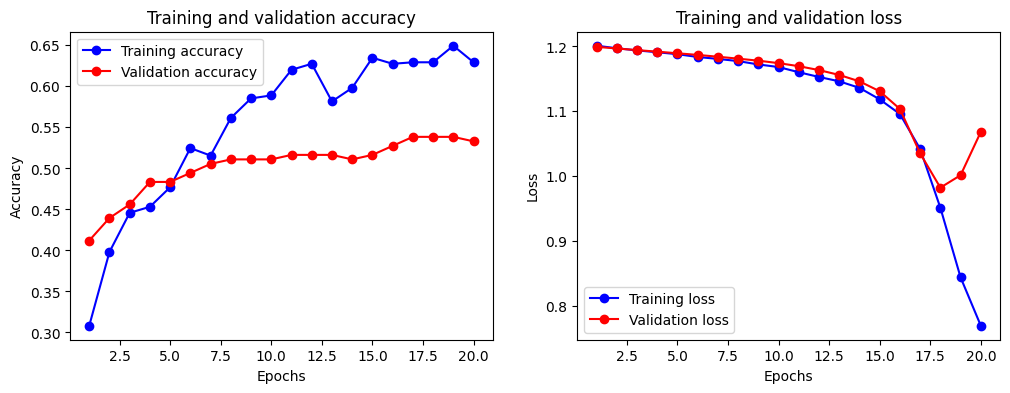

In [ ]:
import matplotlib.pyplot as plt
accuracy = lstm_history.history['accuracy']
val_accuracy = lstm_history.history['val_accuracy']
loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
y_pred_lstm = np.argmax(lstm_model.predict(test_padded), axis=1)
y_pred_prob_lstm = lstm_model.predict(test_padded)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve

YY_ts_lstm = np.argmax(test_labels, axis=1)

metrics = {
    "Accuracy": accuracy_score(YY_ts_lstm, y_pred_lstm),
    "Precision": precision_score(YY_ts_lstm, y_pred_lstm, average='weighted'),
    "Recall": recall_score(YY_ts_lstm, y_pred_lstm, average='weighted'),
    "F1 Score": f1_score(YY_ts_lstm, y_pred_lstm, average='weighted'),
    "ROC AUC": roc_auc_score(YY_ts_lstm, y_pred_prob_lstm, multi_class='ovr')
}

metrics_df_LSTM = pd.DataFrame(metrics, index=[0])
print(metrics_df_LSTM)


   Accuracy  Precision    Recall  F1 Score   ROC AUC
0  0.626374   0.605897  0.626374  0.605503  0.797023


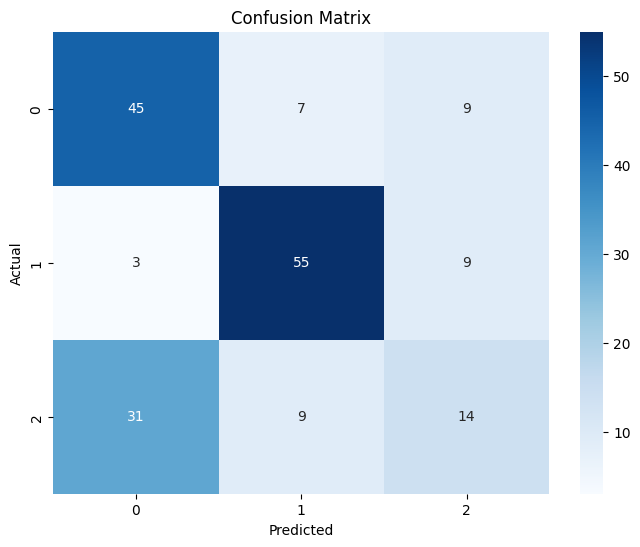

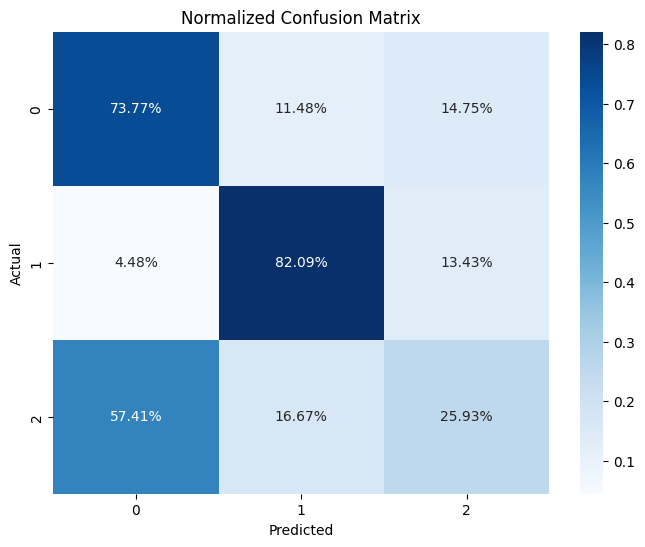

In [ ]:
import seaborn as sns
conf_matrix = confusion_matrix(YY_ts_lstm, y_pred_lstm)
norm_conf_matrix = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(norm_conf_matrix, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()


In [ ]:
#Calculamos de nuevo el accuracy en los 3 conjuntos y los ponemos en una tabla.
train_predictions_lstm = lstm_model.predict(train_padded)
train_accuracy_lstm = np.mean(np.argmax(train_predictions_lstm, axis=1) == np.argmax(train_labels, axis=1))

val_predictions_lstm = lstm_model.predict(val_padded)
val_accuracy_lstm = np.mean(np.argmax(val_predictions_lstm, axis=1) == np.argmax(val_labels, axis=1))

test_predictions_lstm = lstm_model.predict(test_padded)
test_accuracy_lstm = np.mean(np.argmax(test_predictions_lstm, axis=1) == np.argmax(test_labels, axis=1))

accuracy_data = {
    "Dataset": ["Train", "Validation", "Test"],
    "Accuracy": [train_accuracy_lstm, val_accuracy_lstm, test_accuracy_lstm]
}

accuracy_df_lstm = pd.DataFrame(accuracy_data)
print(accuracy_df_lstm)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
      Dataset  Accuracy
0       Train  0.688073
1  Validation  0.532967
2        Test  0.626374


MODELO GRU.

In [ ]:
def create_gru_model(vocab_size, embedding_dim, input_length):
    model = models.Sequential([
        layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
        layers.GRU(128, return_sequences=True),
        layers.GlobalMaxPooling1D(),
        layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.4),
        layers.Dense(3, activation='softmax')
    ])
    set_seed(122)
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
vocab_size = 10000
embedding_dim = 100
input_length = max_len

gru_model = create_gru_model(vocab_size, embedding_dim, input_length)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
gru_history = gru_model.fit(
    train_padded,
    train_labels,
    validation_data=(val_padded, val_labels),
    epochs=20,
    batch_size=64
)


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.3404 - loss: 1.1846 - val_accuracy: 0.4505 - val_loss: 1.1816
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3587 - loss: 1.1818 - val_accuracy: 0.5165 - val_loss: 1.1793
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4360 - loss: 1.1781 - val_accuracy: 0.5440 - val_loss: 1.1769
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4902 - loss: 1.1740 - val_accuracy: 0.5714 - val_loss: 1.1744
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5359 - loss: 1.1701 - val_accuracy: 0.5440 - val_loss: 1.1718
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5899 - loss: 1.1660 - val_accuracy: 0.5055 - val_loss: 1.1690
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6465 - loss: 1.1622 - val_accuracy: 0.5055 - val_loss: 1.1660
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5973 - loss: 1.1579 - val_accuracy: 0.5000 - val_loss: 1.1628


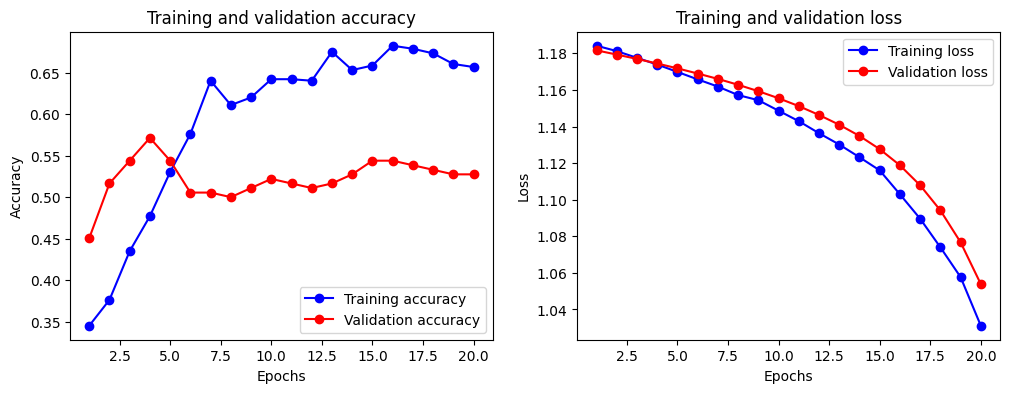

In [ ]:
accuracy = gru_history.history['accuracy']
val_accuracy = gru_history.history['val_accuracy']
loss = gru_history.history['loss']
val_loss = gru_history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
y_pred_gru = np.argmax(gru_model.predict(test_padded), axis=1)
y_pred_prob_gru = gru_model.predict(test_padded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [ ]:
YY_ts_gru = np.argmax(test_labels, axis=1)

metrics = {
    "Accuracy": accuracy_score(YY_ts_gru, y_pred_gru),
    "Precision": precision_score(YY_ts_gru, y_pred_gru, average='weighted'),
    "Recall": recall_score(YY_ts_gru, y_pred_gru, average='weighted'),
    "F1 Score": f1_score(YY_ts_gru, y_pred_gru, average='weighted'),
    "ROC AUC": roc_auc_score(YY_ts_gru, y_pred_prob_gru, multi_class='ovr')
}

metrics_df_gru = pd.DataFrame(metrics, index=[0])
print(metrics_df_gru)

   Accuracy  Precision    Recall  F1 Score   ROC AUC
0  0.554945   0.394058  0.554945  0.456643  0.815686


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


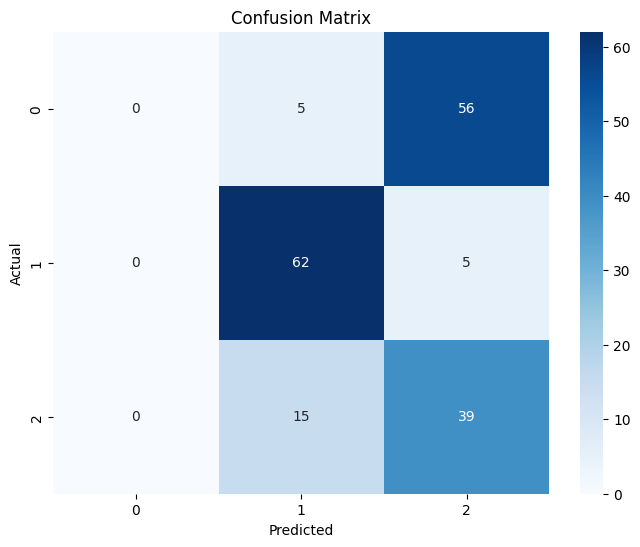

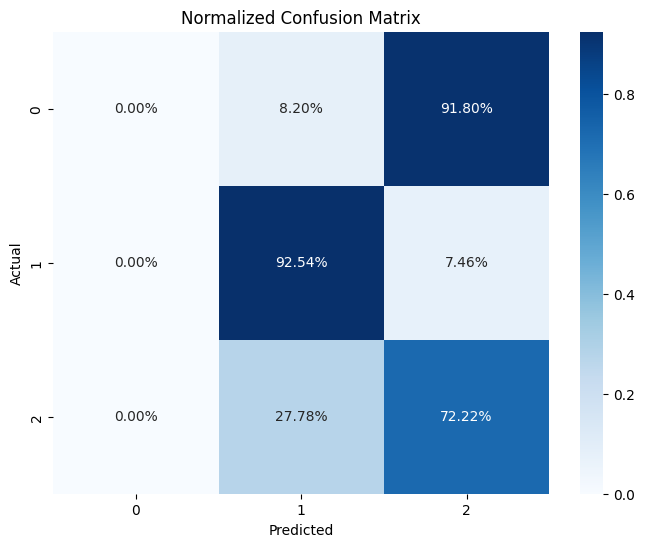

In [ ]:
conf_matrix = confusion_matrix(YY_ts_gru, y_pred_gru)
norm_conf_matrix = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(norm_conf_matrix, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
#Calculamos de nuevo el accuracy en los 3 conjuntos y los ponemos en una tabla.
train_predictions_gru = gru_model.predict(train_padded)
train_accuracy_gru = np.mean(np.argmax(train_predictions_gru, axis=1) == np.argmax(train_labels, axis=1))

val_predictions_gru = gru_model.predict(val_padded)
val_accuracy_gru = np.mean(np.argmax(val_predictions_gru, axis=1) == np.argmax(val_labels, axis=1))

test_predictions_gru = gru_model.predict(test_padded)
test_accuracy_gru = np.mean(np.argmax(test_predictions_gru, axis=1) == np.argmax(test_labels, axis=1))

accuracy_data = {
    "Dataset": ["Train", "Validation", "Test"],
    "Accuracy": [train_accuracy_gru, val_accuracy_gru, test_accuracy_gru]
}

accuracy_df_gru = pd.DataFrame(accuracy_data)
print(accuracy_df_gru)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
      Dataset  Accuracy
0       Train  0.620183
1  Validation  0.527473
2        Test  0.554945


MODELO CONV1D.

In [ ]:
def create_conv1d_model(vocab_size, embedding_dim, input_length):
    model = models.Sequential([
        layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
        layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.GlobalMaxPooling1D(),
        layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002)),
        layers.Dropout(0.6),
        layers.Dense(3, activation='softmax')
    ])
    set_seed(122)
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
vocab_size = 10000
embedding_dim = 100
input_length = max_len

CONVmodel = create_conv1d_model(vocab_size, embedding_dim, input_length)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
conv_history = gru_model.fit(
    train_padded,
    train_labels,
    validation_data=(val_padded, val_labels),
    epochs=20,
    batch_size=64
)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6809 - loss: 0.9966 - val_accuracy: 0.5275 - val_loss: 1.0216
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6578 - loss: 0.9508 - val_accuracy: 0.5275 - val_loss: 0.9741
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6439 - loss: 0.8760 - val_accuracy: 0.5275 - val_loss: 0.9323
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6450 - loss: 0.7508 - val_accuracy: 0.5385 - val_loss: 0.9679
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6641 - loss: 0.6753 - val_accuracy: 0.5495 - val_loss: 1.0333
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6249 - loss: 0.6356 - val_accuracy: 0.5385 - val_loss: 1.0767
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6602 - loss: 0.6118 - val_accuracy: 0.5769 - val_loss: 1.1732
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6926 - loss: 0.5992 - val_accuracy: 0.5495 - val_loss: 1.2602


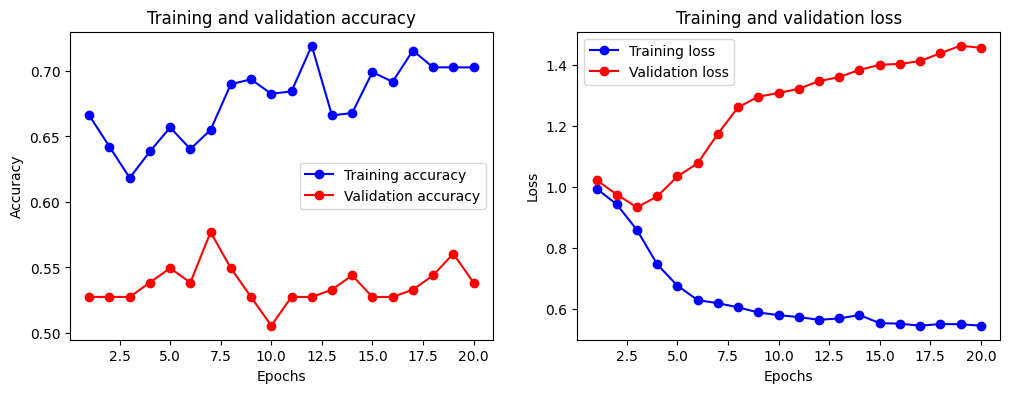

In [ ]:
accuracy = conv_history.history['accuracy']
val_accuracy = conv_history.history['val_accuracy']
loss = conv_history.history['loss']
val_loss = conv_history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
y_pred = np.argmax(CONVmodel.predict(test_padded), axis=1)
y_pred_prob = CONVmodel.predict(test_padded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [ ]:
YY_ts = np.argmax(test_labels, axis=1)

metrics = {
    "Accuracy": accuracy_score(YY_ts, y_pred),
    "Precision": precision_score(YY_ts, y_pred, average='weighted'),
    "Recall": recall_score(YY_ts, y_pred, average='weighted'),
    "F1 Score": f1_score(YY_ts, y_pred, average='weighted'),
    "ROC AUC": roc_auc_score(YY_ts, y_pred_prob, multi_class='ovr')
}

metrics_df_conv = pd.DataFrame(metrics, index=[0])
print(metrics_df_conv)

   Accuracy  Precision    Recall  F1 Score  ROC AUC
0  0.318681   0.256227  0.318681  0.179914  0.46527


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


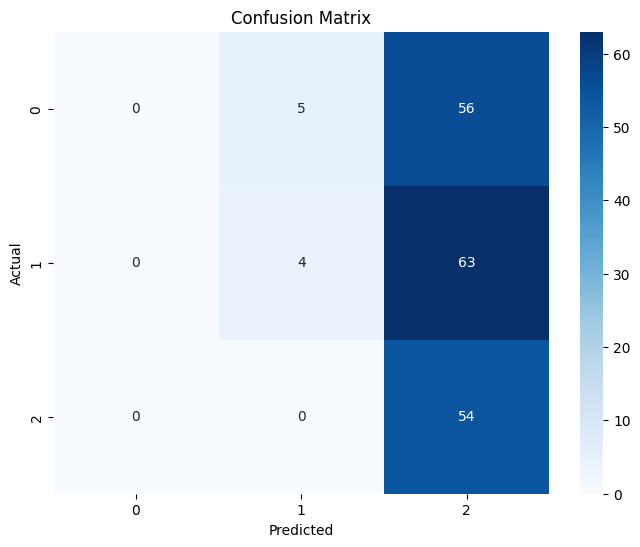

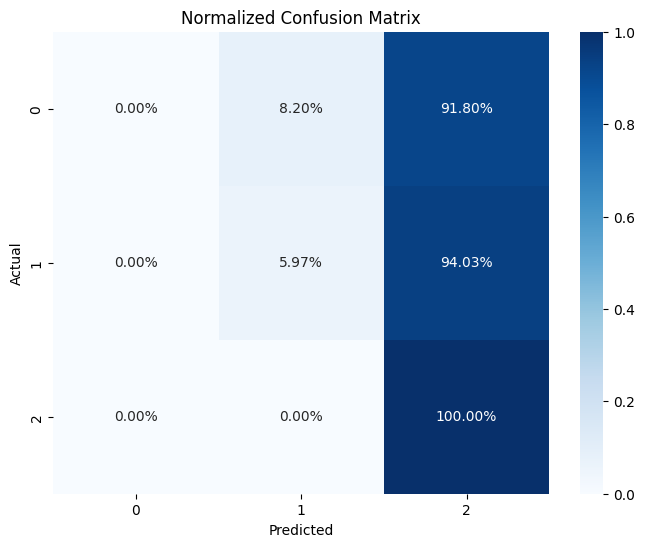

In [ ]:
conf_matrix = confusion_matrix(YY_ts, y_pred)
norm_conf_matrix = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(norm_conf_matrix, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
#Calculamos de nuevo el accuracy en los 3 conjuntos y los ponemos en una tabla.
train_predictions_cov = CONVmodel.predict(train_padded)
train_accuracy_cov = np.mean(np.argmax(train_predictions_cov, axis=1) == np.argmax(train_labels, axis=1))

val_predictions_cov = CONVmodel.predict(val_padded)
val_accuracy_cov = np.mean(np.argmax(val_predictions_cov, axis=1) == np.argmax(val_labels, axis=1))

test_predictions_cov = CONVmodel.predict(test_padded)
test_accuracy_cov = np.mean(np.argmax(test_predictions_cov, axis=1) == np.argmax(test_labels, axis=1))

accuracy_data = {
    "Dataset": ["Train", "Validation", "Test"],
    "Accuracy": [train_accuracy_cov, val_accuracy_cov, test_accuracy_cov]
}

accuracy_df_cov = pd.DataFrame(accuracy_data)
print(accuracy_df_cov)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
      Dataset  Accuracy
0       Train  0.350459
1  Validation  0.346154
2        Test  0.318681


Creación de la tabla:

In [ ]:
accuracy_df_lstm['Model'] = 'LSTM'
accuracy_df_gru['Model'] = 'GRU'
accuracy_df_cov['Model'] = 'Conv1D'


In [ ]:
df_accuracy_combined = pd.concat([accuracy_df_lstm, accuracy_df_gru, accuracy_df_cov], ignore_index=True)

In [ ]:
df_accuracy_combined

,Dataset,Accuracy,Model
0,Train,0.688073,LSTM
1,Validation,0.532967,LSTM
2,Test,0.626374,LSTM
3,Train,0.620183,GRU
4,Validation,0.527473,GRU
5,Test,0.554945,GRU
6,Train,0.350459,Conv1D
7,Validation,0.346154,Conv1D
8,Test,0.318681,Conv1D


Comparación entre Modelos
Rendimiento General:

El LSTM ha mostrado el mejor rendimiento en el conjunto de entrenamiento, lo que sugiere que es capaz de aprender más del conjunto de datos en comparación con los otros modelos.

El GRU ha mostrado un rendimiento ligeramente mejor en validación y prueba, lo que sugiere que puede generalizar un poco mejor que el LSTM, aunque ambos tienen problemas significativos de generalización.

El Conv1D claramente tiene el peor rendimiento en todos los conjuntos de datos, lo que indica que esta arquitectura no es adecuada para este problema específico, o que la implementación actual del modelo necesita ajustes importantes.

Sobreajuste y Generalización:

LSTM muestra signos de estar ajustándose demasiado a los datos de entrenamiento, con una caída significativa en precisión al pasar a validación y prueba.

GRU parece estar generalizando un poco mejor que LSTM, pero todavía tiene problemas, lo que sugiere que puede ser una mejor opción entre los dos, aunque no ideal.

Conv1D no muestra signos de sobreajuste, pero esto es porque el modelo no está aprendiendo bien en primer lugar. La precisión baja en todos los conjuntos sugiere que este modelo está subentrenado o no es adecuado para este tipo de datos.

Tiny transformer.

Para el tiny-transformer he utilizado el modelo que vimos en clase.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_nlp
vocab_size = 10000
sequence_length = 30

token_id_input = keras.Input(
    shape=(None,),
    dtype="int32",
    name="token_ids",
)

outputs = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=vocab_size,
    sequence_length=sequence_length,
    embedding_dim=64,
)(token_id_input)

outputs = keras_nlp.layers.TransformerEncoder(
    num_heads=2,
    intermediate_dim=64,
    dropout=0.4,
)(outputs)

outputs = keras.layers.Dense(3, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.01))(outputs[:, 0, :])

model = keras.Model(
    inputs=token_id_input,
    outputs=outputs,
)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ token_ids (InputLayer)               │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, None, 64)            │         641,920 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder                  │ (None, None, 64)            │          25,216 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 667,331 (2.55 MB)

 Trainable params: 667,331 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_padded,
    train_labels,
    validation_data=(val_padded, val_labels),
    epochs=20,
    batch_size=32
)


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 661ms/step - accuracy: 0.3629 - loss: 1.4159 - val_accuracy: 0.4451 - val_loss: 1.1289
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6103 - loss: 0.9122 - val_accuracy: 0.4945 - val_loss: 1.0641
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6828 - loss: 0.7741 - val_accuracy: 0.4725 - val_loss: 1.0489
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7530 - loss: 0.6437 - val_accuracy: 0.5055 - val_loss: 1.0372
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8061 - loss: 0.4768 - val_accuracy: 0.5604 - val_loss: 1.0211
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8471 - loss: 0.3986 - val_accuracy: 0.5824 - val_loss: 0.9967
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8934 - loss: 0.3224 - val_accuracy: 0.5714 - val_loss: 1.1026
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9222 - loss: 0.2805 - val_accuracy: 0.6154 - val_lo

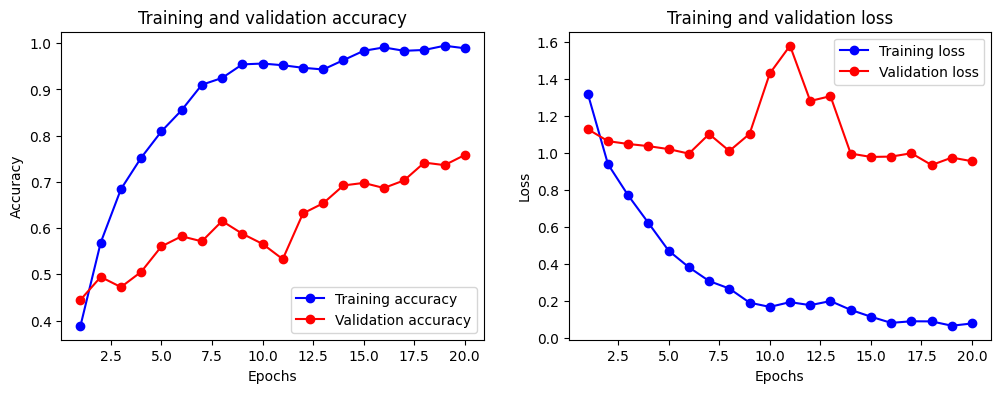

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


In [ ]:
train_predictions = np.argmax(model.predict(train_padded), axis=1)
train_accuracy = accuracy_score(np.argmax(train_labels, axis=1), train_predictions)

val_predictions = np.argmax(model.predict(val_padded), axis=1)
val_accuracy = accuracy_score(np.argmax(val_labels, axis=1), val_predictions)

test_predictions = np.argmax(model.predict(test_padded), axis=1)
test_accuracy = accuracy_score(np.argmax(test_labels, axis=1), test_predictions)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train Accuracy: 1.0000
Validation Accuracy: 0.7582
Test Accuracy: 0.7582


Aunque es evidente el sobreentrenamiento, la generalización del modelo a los datos de validación y prueba es relativamente buena.